### Assignment: Centrality Measures
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)

The [Cocktail DB](https://www.thecocktaildb.com/api.php) is a database of cocktails and ingredients. In this assignment, we describe how we could use the Cocktail DB's API to generate a network of cocktails and ingredients. We can use some example data to explore how we might be able to predict outcomes from this data using centrality metrics. 

##### Loading the Data

Without digging too deeply into the intricacies of the Cocktail DB API, we can leverage [this code](https://holypython.com/api-12-cocktail-database/) as a start for grabbing some example output from the API. This code leverages 2 libraries: `requests` to make an API request, and `json` to load the JSON output from the API. We can then iterate through each cocktail output to grab the relevant components. 

In this case, we're grabbing a sample of cocktail recipes that include Gin in the title. Were we to broaden this output, we could adjust the search query to pull all cocktail names (`strDrink`), the top 3 ingredients for each, and the drink categories (`strCategory`) for each cocktail.

In [68]:
import networkx as net
import requests
import json
def cocktails(G):
    f = r"https://www.thecocktaildb.com/api/json/v1/1/search.php?s=gin"
    data = requests.get(f)
    tt = json.loads(data.text)

    for i in (tt["drinks"]):
        G.add_edge(i["strDrink"],i["strIngredient1"],category=i["strCategory"])
        G.add_edge(i["strDrink"],i["strIngredient2"],category=i["strCategory"])
        G.add_edge(i["strDrink"],i["strIngredient3"],category=i["strCategory"])
        #G[i["strDrink"]]["category"] = i["strCategory"] Does it make more sense to have node or edges categorized?
    return G

In [69]:
cocktail_graph=net.Graph()
cocktails(cocktail_graph)

We can see a quick visualization of this output below - we see the ingredient Gin as a center node, with other ingredients shared as well.

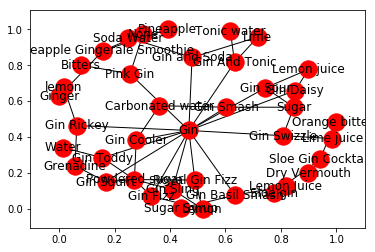

In [72]:
net.draw_networkx(cocktail_graph)

In [74]:
# can we color by category? gephi?

#### To Add 

From assignment: "In addition to identifying your data source, you should create a high level plan that describes how you would load the data for analysis, and describe a hypothetical outcome that could be predicted from comparing degree centrality across categorical groups. "

Notes: 
- commonality of different ingredients?
- how to stock your bar? 
- comparing across categorical group - "category" ingredients in "classic" categories might have higher centrality? more commonly used less niche?
